In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import joblib
from tqdm import tqdm

from strategy import strategies
from feature_engineering import feature_functions

feature_engineer = feature_functions["15_dir"]
feature_engineer_vol =  feature_functions["15_dir"]
# get_quotes = strategies["test_new_pow_no_sqrt"]
get_quotes = strategies["strategy:1.0"]

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from math import log

# Feature Engineer

In [2]:
def process_data(df):
    features = feature_engineer(df)

    mid = (df["bid1_price"] + df["ask1_price"])/2
    mid = mid.apply(np.log).diff().shift(-1)
    targets = mid
    return features, targets

# Open data and predict

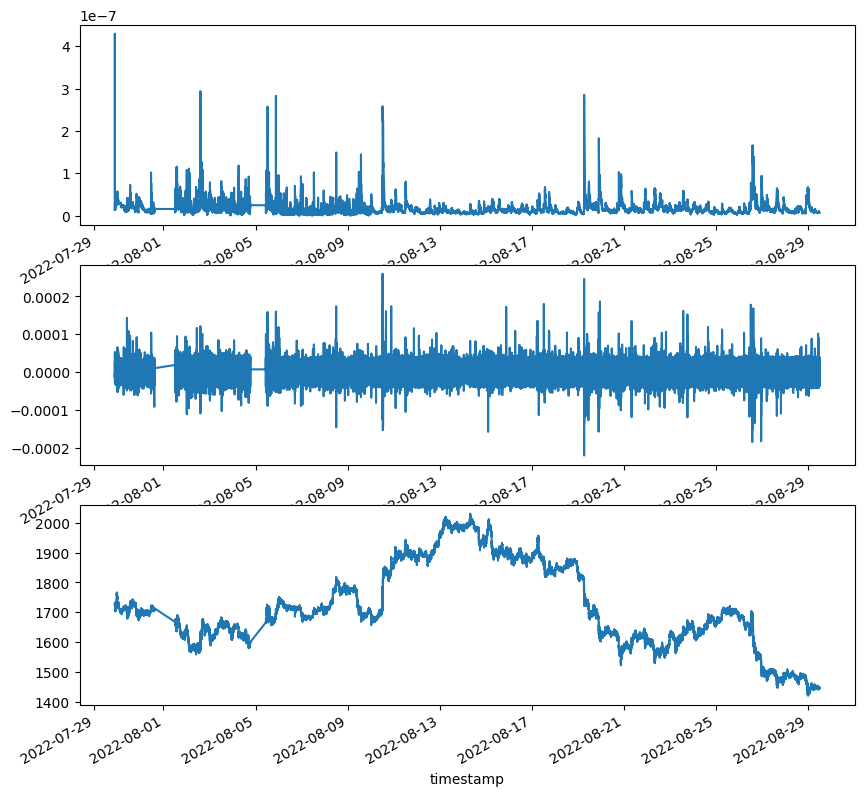

<Axes: xlabel='timestamp'>

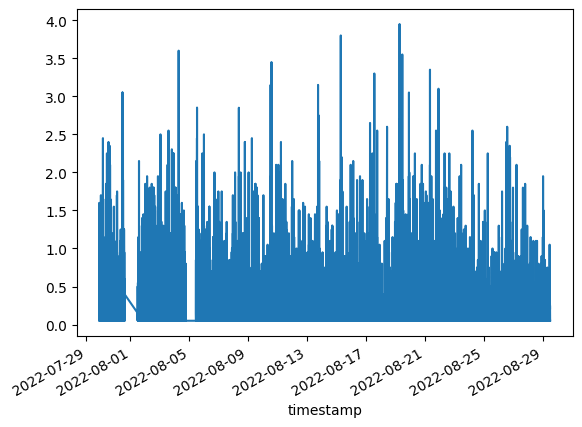

In [3]:
found = True
i = 0
exclude = []

feature_frames = []
target_frames = []
full_df_frames = []
df_frames = []

instrument = "ETH-PERPETUAL"

path = f"/Users/joeybesseling/Documents/Programmeren/Projects/Data/PROCESSED_{instrument}/"
instrument = f"{instrument}"
interval = 1
depth = 20
pre_proc = True

if pre_proc:
    features = pd.read_parquet(path + f"processed_features_{instrument}_{interval}s.parquet")
    df = features.copy()
    df["min_bid"] = df.bid1_price.shift(-1)
    df["max_ask"] = df.ask1_price.shift(-1)
    full_dfs = df.copy()
else:
    for i in range(70,71): # 350-660 # 1 - 880
        df = pd.read_parquet(path + f"{instrument}_1_{depth}({i}).parquet")
        df["timestamp"] = pd.to_datetime(df.timestamp)
        df = df.set_index("timestamp", drop = True)
        df = df.drop("Unnamed: 0", axis = 1)
        if interval > 1:
            for column in df.columns:
                if "trade" in column:
                    df[column] = df[column].rolling(interval).sum()
        df["min_bid"] = df.bid1_price.rolling(interval).min()
        df["max_ask"] = df.ask1_price.rolling(interval).max()
        df = df.resample(f"{interval}s").last()
        features, targets = process_data(df)
        
        features = features[targets.notna()]
        df = df[targets.notna()]
        targets = targets[targets.notna()]

        df_frames.append(df)
        feature_frames.append(features)
        target_frames.append(targets)
        print(i)
    df = pd.concat(df_frames)
    full_dfs = df.copy()
    features = pd.concat(feature_frames)

model = joblib.load(f"models/{instrument}_model_{interval}s_regr.joblib")
model_vol = joblib.load(f"models/{instrument}_model_{interval}s_vol.joblib")

prediction_vol = pd.DataFrame({"prediction_vol": model_vol.predict(features)})
prediction_vol.index = features.index
full_df = pd.merge(full_dfs, prediction_vol, left_index=True, right_index=True)

prediction = pd.DataFrame({"prediction": model.predict(features)})
prediction.index = features.index
full_df = pd.merge(full_df, prediction["prediction"], left_index = True, right_index = True)

fig, axs = plt.subplots(3, 1, figsize = (10, 10))
full_df["prediction_vol"] = full_df.vol_0.ewm(halflife = 900).mean()
# full_df["prediction_vol"] = full_df["prediction_vol"].ewm(halflife=900, min_periods=0).mean()
full_df["prediction_vol"].plot(ax = axs[0])
full_df["prediction"].plot(ax = axs[1])
full_df["bid1_price"].plot(ax =axs[2])
plt.show()

(full_df["ask1_price"] - full_df["bid1_price"] ).plot()

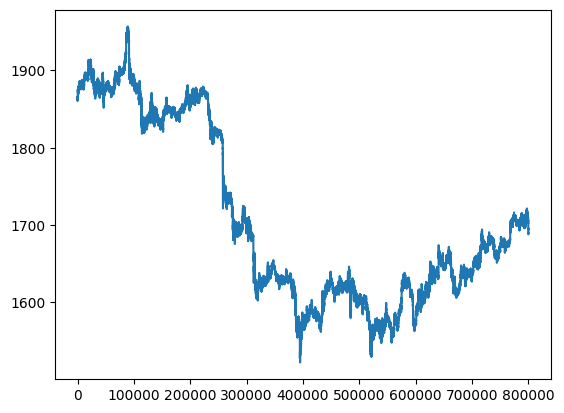

In [46]:
plt.plot(df.bid1_price.values[int(2e6):int(2e6) + int(8e5)])
plt.show()

In [ ]:
class BackTest():
    def __init__(self, df):
        self.df = df
        self.pos = 0
        self.trade_hist = []

        # strategy parameters
        self.tick = .5
        self.sign = 1
        self.min_quantity = 10
        self.qty = 100

        self.avg_buy = []
        self.avg_sell = []
        self.vol_buy = []
        self.vol_sell = []

        self.avg_buy_prev = []
        self.avg_sell_prev = []

        self.ask_quote_distance = []
        self.bid_quote_distance = []

        self.posHist = []
        
    def return_quote_size(self, pred, pred_vol, best_bid, best_ask, t = None):
        # determine quotes
        # bid_quote, ask_quote = get_quotes(best_bid, best_ask, pred, pred_vol, self.pos, MULT2 = MULT2, MULT = MULT, TRADE_QTY=TRADE_QTY, BASE_SPREAD = BASE_SPREAD, MAX_POS = MAX_POSITION_N, BOOK_LIQ = BOOK_LIQ , MIN_SPREAD=MIN_SPREAD, RISK_AVERSION = RISK_AVERSION, FACT = FACT)        
        # bid_quote, ask_quote = get_quotes(self.df.iloc[t], self.pos, TRADE_QTY, RISK_AVERSION, MAX_POSITION_N, THRESHOLD, MULT2, BASE_SPREAD, MIN_SPREAD, FACT)
        strategy_params = {
            "trade_qty": TRADE_QTY,
            "max_pos": MAX_POSITION_N,
            "max_position": MAX_POSITION_N,
            "risk_aversion":RISK_AVERSION,
            "min_spread": MIN_SPREAD,
            "base_spread": BASE_SPREAD,
            "vol_mult": MULT,
            "dir_mult": MULT2,
            "threshold": THRESHOLD, #1.7e-6
            "min_quote": 1000,
            "max_quote": 100000,            
            "ML_model": "AlphaIntelligence_beta",
        }
        bid_order, ask_order = get_quotes(data = \
            {
                # "book": self.df.iloc[t], 
                "book": {
                    "bids":[[self.df.iloc[t]["bid1_price"]],],
                    "asks": [[self.df.iloc[t]["ask1_price"]],]
                },
                "dir": pred, 
                "vol": pred_vol, 
                "pos": self.pos
            }, 
            params = strategy_params)

        bid_quote, ask_quote = bid_order["price"], ask_order["price"]
        bid_quote = round(round(bid_quote/self.tick)*self.tick, self.sign)
        ask_quote = round(round(ask_quote/self.tick)*self.tick, self.sign)
        bid_quote = min(best_ask-self.tick, bid_quote)
        ask_quote = max(best_bid+self.tick, ask_quote)
        bid_size = TRADE_QTY
        ask_size = TRADE_QTY
        if self.pos >= TRADE_QTY*MAX_POSITION_N:
            bid_size = 0
        if self.pos <= -TRADE_QTY*MAX_POSITION_N:
            ask_size = 0

        self.ask_quote_distance.append(best_ask - bid_quote)
        self.bid_quote_distance.append(-ask_quote + best_bid)

        return bid_quote, bid_size, ask_quote, ask_size

    def one_run(self,t):
        bid_quote, bid_size, ask_quote, ask_size = self.return_quote_size(np.sign(self.df.iloc[t]["prediction"]), max(self.df.iloc[t]["prediction_vol"],0),self.df.iloc[t]["bid1_price"], self.df.iloc[t]["ask1_price"], t)

        if self.df.iloc[t+1]["min_bid"] <= bid_quote and bid_size > 0 and self.df.iloc[t+1]["trade_vol_sell"] > 0:
            self.pos += bid_size
            self.trade_hist.append({"side": "buy", "price": bid_quote, "amount": bid_size})
        if self.df.iloc[t+1]["max_ask"] >= ask_quote and ask_size > 0 and self.df.iloc[t+1]["trade_vol_buy"] > 0:
            self.pos += - ask_size
            self.trade_hist.append({"side": "sell", "price": ask_quote, "amount": ask_size})
        self.posHist.append(self.pos)
        if len(self.trade_hist) >= 2 and self.plot_param:
            avg_buy, avg_sell, vol_buy, vol_sell = self.compute_profit()
            if vol_buy > vol_sell:
                avg_sell = (vol_sell * avg_sell + (vol_buy-vol_sell) * self.df.iloc[t]["bid1_price"]) / vol_buy
            if vol_sell > vol_buy:
                avg_buy = (vol_buy * avg_buy + (vol_sell-vol_buy) * self.df.iloc[t]["ask1_price"]) / vol_sell
            prof = max(vol_buy, vol_sell) * (avg_sell - avg_buy) / avg_buy

            if avg_buy and avg_sell:
                # print(f" {avg_buy} x {vol_buy} | {avg_sell} x {vol_sell} | net: {vol_buy - vol_sell}")
                self.avg_buy.append(avg_buy)
                self.avg_sell.append(avg_sell)
                self.vol_buy.append(vol_buy)
                self.vol_sell.append(vol_sell)
            return prof

    def full_run(self, plot = False, t_start = None,  t_end = None, WAIT_AFTER_KILL = None, TAKE_PROFIT_SWITCH = None, STOP_LOSS_SWITCH = None):
        self.plot_param = plot
        if not t_end:
            t_end = float("inf")
        if not t_start:
            t_start = 0

        for i in tqdm(range(t_start, t_end)):
            self.one_run(i)
            # compute profit each hour
            if i % 3600 == 0:
                if len(self.trade_hist) > 2:
                    avg_buy, avg_sell, vol_buy, vol_sell = self.compute_profit()
                    if vol_buy > vol_sell:
                        avg_sell = (vol_sell * avg_sell + (vol_buy-vol_sell) * self.df.iloc[i]["bid1_price"]) / vol_buy
                    if vol_sell > vol_buy:
                        avg_buy = (vol_buy * avg_buy + (vol_sell-vol_buy) * self.df.iloc[i]["ask1_price"]) / vol_sell
                    prof = max(vol_buy, vol_sell) * (avg_sell - avg_buy) / avg_buy
                    if avg_buy and avg_sell:
                        # print(f" {avg_buy} x {vol_buy} | {avg_sell} x {vol_sell} | net: {vol_buy - vol_sell}")
                        self.avg_buy.append(avg_buy)
                        self.avg_sell.append(avg_sell)
                        self.vol_buy.append(vol_buy)
                        self.vol_sell.append(vol_sell)
        
        if len(self.trade_hist) > 2:
            avg_buy, avg_sell, vol_buy, vol_sell = self.compute_profit()
            try:
                print(f" {avg_buy} x {vol_buy} | {avg_sell} x {vol_sell} | net: {vol_buy - vol_sell}")
                if vol_buy > vol_sell:
                    avg_sell = (vol_sell * avg_sell + (vol_buy-vol_sell) * self.df.iloc[i]["bid1_price"]) / vol_buy
                if vol_sell > vol_buy:
                    avg_buy = (vol_buy * avg_buy + (vol_sell-vol_buy) * self.df.iloc[i]["ask1_price"]) / vol_sell
                print(f"price difference | {round((avg_sell - avg_buy)/avg_buy * 100, 4)}%")
                print(f"profit | {max(vol_buy, vol_sell) * (avg_sell - avg_buy) / avg_buy}")
                if plot:
                    self.plot(t_start, t_end)
                return (avg_sell - avg_buy)/avg_buy, vol_buy + vol_sell
            except:
                return None, None
        else:
            return 0,0
    
    def compute_profit(self,t = None):
        test = pd.DataFrame(self.trade_hist)
        test["sell"] = test["amount"].copy()
        test["sell"][test["side"] != "sell"] = 0

        test["buy"] = test["amount"].copy()
        test["buy"][test["side"]!="buy"] = 0

        test["weighted_buy"] = test["price"] * test["buy"]
        test["weighted_sell"] = test["price"] * test["sell"]

        test["weighted_buy"][test["weighted_buy"]==0] = float("NaN")
        test["weighted_sell"][test["weighted_sell"]==0] = float("NaN")
        return np.nanmean(test["weighted_buy"])/TRADE_QTY, np.nanmean(test["weighted_sell"])/TRADE_QTY, np.nansum(test["buy"]), np.nansum(test["sell"])

    def plot(self, t_start, t_end):
        self.fig, self.axs = plt.subplots(6,1, figsize = (10,10))
        self.axs[0].plot(self.avg_buy, label = "buys")
        self.axs[0].plot(self.avg_sell, label = "sells")
        self.axs[0].legend()
        self.axs[0].set_title(f"min_spread:{MIN_SPREAD} | risk_aver:{RISK_AVERSION} | dp: {MAX_POSITION_N}")
        
        self.axs[1].plot(np.array(self.vol_buy) - np.array(self.vol_sell))
        self.axs[1].set_title("Net position")
        
        self.axs[2].plot(((self.df["bid1_price"]+self.df["ask1_price"])/2).iloc[t_start:t_end])
        self.axs[2].set_title("Price development")
        
        self.axs[3].plot(np.diff(self.vol_buy), label = "bought")
        self.axs[3].plot(np.diff(self.vol_sell), label = "sold")
        self.axs[3].legend()
        self.axs[3].set_title("Executed private orders (bought / sold)")
        
        self.axs[4].plot(self.bid_quote_distance)
        self.axs[4].plot(self.ask_quote_distance)
        self.axs[4].set_title("Spread charged on bid and ask side")
        
        self.axs[5].plot((np.array(self.avg_sell) - np.array(self.avg_buy))/np.array(self.avg_buy)*(np.array(self.vol_buy) + np.array(self.vol_sell))/2)
        self.axs[5].set_title("Net profit (after immediate liquidation)")
        plt.show()


In [53]:
full_df = full_df.fillna(0)
VOLNORM = 1e-7
TRADE_QTY = 10
MIN_QTY = 1
MAX_POSITION_N = 20 # 400
RISK_AVERSION = 20 # 16 # higher gives smaller spreads
BOOK_LIQ = 1
MULT = 10 # 8
MULT2 = .5
FACT = .5 # standard 1, lower is desired
BASE_SPREAD = 0
MIN_SPREAD = .002

df_res = pd.DataFrame({
    "RISK_AVERSION": [],
    "BOOK_LIQ": [],
    "MULT": [],
    "MIN_SPREAD": [],
    "BASE_SPREAD": [],
    "MAX_POS": [],
    "MULT2": [],
    "FACT": [],
    "THRESHOLD": [],
    "PCT": [],
    "VOLUME_TOT": [],
})

# max_position, base_spread, min_spread
i = 0
for RISK_AVERSION in [16]: # 100
    for MIN_SPREAD in [4e-5]: # .0007
            for MAX_POSITION_N in [20]: # 20
                for MULT2 in [1e4]: # direction multiplier
                    for MULT in [.0032]: # volatility multiplier
                        for BASE_SPREAD in [0.]: # .0007
                            for FACT in [2]:
                                for THRESHOLD in [.35]:
                                    print('-------------------------------------------------------')
                                    print(f"BASE_SPREAD {BASE_SPREAD} | MULT {MULT} | MULT2 {MULT2} | RISK_AVERSION {RISK_AVERSION} | BOOK_LIQ {BOOK_LIQ} | MIN_SPREAD {MIN_SPREAD} | MAX_POS_N {MAX_POSITION_N} ")
                                    sim = BackTest(full_df)
                                    profit_margin, total_volume = sim.full_run(plot=False, t_start = int(2e6) + int(4e5), t_end = int(2e6) + int(6e5))
                                    df_res.loc[i] = [RISK_AVERSION, BOOK_LIQ, MULT, MIN_SPREAD, BASE_SPREAD, MAX_POSITION_N, MULT2, FACT, THRESHOLD, profit_margin, total_volume]
                                    i += 1

# RISK_AVERSION = 1
# MIN_SPREAD = .0008
# MAX_POSITION_N = 10 
# MULT2 = 40e3
# MULT = 0.0004
# BASE_SPREAD = 0.  
# FACT = 2
# THRESHOLD = .35                  
# print(f"BASE_SPREAD {BASE_SPREAD} | MULT {MULT} | MULT2 {MULT2} | RISK_AVERSION {RISK_AVERSION} | BOOK_LIQ {BOOK_LIQ} | MIN_SPREAD {MIN_SPREAD} | MAX_POS_N {MAX_POSITION_N} ")
# sim = BackTest(full_df)
# profit_margin, total_volume = sim.full_run(plot=True, t_start = int(.9e4), t_end = int(1.11e4))
# df_res.loc[i] = [RISK_AVERSION, BOOK_LIQ, MULT, MIN_SPREAD, BASE_SPREAD, MAX_POSITION_N, MULT2, FACT, THRESHOLD, profit_margin, total_volume]
# i += 1
                                    
# print('-------------------------------------------------------')
# prof_list = []
# for i in range(10):
#     sim = BackTest(full_df)
#     margin, volume = sim.full_run(plot=False, t_start = int(i*6e4), t_end = int((i+1)*5e4))
#     prof = margin * volume/2
#     prof_list.append(prof)
# plt.hist(prof_list)
# plt.show()
# sim = BackTest(full_df)
# a,b = sim.full_run(plot=True, t_start = 0, t_end = 14000, TAKE_PROFIT_SWITCH=.5, STOP_LOSS_SWITCH=-.5, WAIT_AFTER_KILL=10)

-------------------------------------------------------
BASE_SPREAD 0.0 | MULT 0.0032 | MULT2 10000.0 | RISK_AVERSION 16 | BOOK_LIQ 1 | MIN_SPREAD 4e-05 | MAX_POS_N 20 


100%|██████████| 200000/200000 [00:56<00:00, 3559.37it/s]

 1680.5658023483368 x 20440 | 1680.5301128003925 x 20390 | net: 50
price difference | -0.0033%
profit | -0.6759628206226874


In [42]:
df_res = df_res.sort_values("PCT",ascending=False, ignore_index=True)
# df_res.to_csv("testingcsv"
# df_res[df_res["VOLUME_TOT"]>1000].iloc[:50]
df_res.head(50)

,RISK_AVERSION,BOOK_LIQ,MULT,MIN_SPREAD,BASE_SPREAD,MAX_POS,MULT2,FACT,THRESHOLD,PCT,VOLUME_TOT
0,16.0,1.0,0.0032,0.0004,0.0,20.0,0.0,2.0,0.35,0.000042,1790.0


In [ ]:
plt.plot(np.cumsum(prof_list))
print(min(prof_list), max(prof_list))
plt.show()

plt.plot(np.cumsum(prof_list) - np.maximum.accumulate(np.cumsum(prof_list)))
plt.show()

plt.plot(prof_list)
plt.show()

In [ ]:
ret = np.diff((np.array(sim.avg_sell) - np.array(sim.avg_buy))/np.array(sim.avg_buy)*(np.array(sim.vol_buy) + np.array(sim.vol_sell))/2)

In [ ]:
plt.hist(ret, bins = 50)
plt.show()
plt.plot(ret.cumsum())
plt.show()
plt.plot(ret)
plt.show()
print(f"{ret.mean() / ret.std()}")
print(f"{ret.sum() / ret.std()}")

In [ ]:
res = full_df.copy()
res["new"] = res.index
difference = res["new"].diff()
difference[difference > pd.Timedelta(60, unit = "s")]

In [ ]:
full_df.bid1_price.iloc[-400000:].plot()
print(f"n-features: {full_df.shape[0]}")

In [ ]:
full_df.index.shape
full_df.index.value_counts().iloc[:60]

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
test = pd.DataFrame(sim.trade_hist)
test["sell"] = test["amount"].copy()
test["sell"] = 0
test["sell"][test["side"] == "sell"] = 1
test["buy"] = test["amount"].copy()
test["buy"] = 0
test["buy"][test["side"]=="buy"] = 1
test["weighted_buy"] = test["price"] * test["buy"]
test["weighted_sell"] = test["price"] * test["sell"]
test["weighted_buy"][test["weighted_buy"]==0] = float("NaN")
test["weighted_sell"][test["weighted_sell"]==0] = float("NaN")
test["weighted_sell"].mean(), test["weighted_buy"].mean()
    
def compute_profit(self,):
    test = pd.DataFrame(self.trade_hist)
    test["sell"] = test["amount"].copy()
    test["sell"] = 0
    test["sell"][test["side"] == "sell"] = 1
    test["buy"] = test["amount"].copy()
    test["buy"] = 0
    test["buy"][test["side"]=="buy"] = 1
    test["weighted_buy"] = test["price"] * test["buy"]
    test["weighted_sell"] = test["price"] * test["sell"]
    test["weighted_buy"][test["weighted_buy"]==0] = float("NaN")
    test["weighted_sell"][test["weighted_sell"]==0] = float("NaN")
    return test["weighted_sell"].mean(), test["weighted_buy"].mean(), test["buy"].sum()*TRADE_QTY, test["sell"].sum()*TRADE_QTY

def compute_profit(self):
    def wma(array):
        return sum([t[0]*t[1] for t in array]) / sum([t[0] for t in array])
    buys = [[trade["amount"], trade["price"]] for trade in self.trade_hist if trade["side"] == "buy"]
    sells = [[trade["amount"], trade["price"]] for trade in self.trade_hist if trade["side"] == "sell"]
    try:
        buy_avg = wma(np.array(buys))
        sell_avg = wma(np.array(sells))
    except:
        buy_avg = None
        sell_avg = None
        return None, None, None, None

    return round(buy_avg,3), round(sell_avg,3) , sum([trade[0] for trade in buys]), sum([trade[0] for trade in sells])

test["weighted_buy_rolling"] = test["weighted_sell"].expanding().mean()
test["weighted_sell_rolling"] = test["weighted_buy"].expanding().mean()
test["weighted_sell_rolling"].plot(label = "sell")
test["weighted_buy_rolling"].plot(label = "buy")
plt.show()
print(test.iloc[-1])


In [ ]:
test["position"] = (test["buy"].cumsum() - test["sell"].cumsum())*10
test["position"].plot()

In [ ]:
import pandas as pd
pd.read_parquet("/Users/joeybesseling/Documents/Programmeren/Projects/Data/BTC-PERPETUAL/BTC-PERPETUAL_1_20(30).parquet")

In [ ]:
plt.plot(sim.posHist)